In [1]:
import torch

def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [3]:
if IN_COLAB:
    PATH_TO_DATA = '/content/'
else:
    PATH_TO_DATA = './data/'

# Copy data 

In [5]:
BASE_PATH = '/content/drive/MyDrive/ai/detect-flood-water/'

In [6]:
!ls {BASE_PATH}

detect-flood-water	flood-training-metadata.csv  training_results.ipynb
flood-train-images.tgz	flood-train-labels.tgz


In [7]:
%%time
file_name = 'flood-train-images.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 269 ms, sys: 65.7 ms, total: 335 ms
Wall time: 37.3 s


In [8]:
%%time
file_name = 'flood-train-labels.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 10.1 ms, sys: 15.9 ms, total: 26 ms
Wall time: 634 ms


In [9]:
file_name = 'flood-training-metadata.csv'
file_path = BASE_PATH + file_name

!cp {file_path} .

# Imports

In [4]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [5]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
os.chdir("/content/drive/My Drive/ai/detect-flood-water/detect-flood-water/")

In [7]:
!pip install rasterio
!pip install pandas_path
!pip install segmentation_models_pytorch

In [8]:
from utils import seed_everything
from plot_utils import show_image, show_image_and_label, show_train_metrics, show_loss_and_score

In [9]:
seed = 2021
seed_everything(seed)

# Git repo 

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   detect-flood-water-train.ipynb
	new file:   main.py
	modified:   metrics.py
	new file:   plot_utils.py
	modified:   train.py



In [ ]:
!git add .

In [ ]:
!git config --global user.email "michael.kalinin.nn@gmail.com"
!git config --global user.name "michaelka"

In [ ]:
!git commit -m "[colab] Take slices with interval"

# Load data 

In [ ]:
from dataset import FloodDataset

In [ ]:
from pathlib import Path
from pandas_path import path

In [ ]:
os.listdir(PATH_TO_DATA)

['.config',
 'flood-train-labels.tgz',
 'train_features',
 'flood-training-metadata.csv',
 'train_labels',
 'flood-train-images.tgz',
 'drive',
 'sample_data']

In [ ]:
train_metadata = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'flood-training-metadata.csv'),
    parse_dates=["scene_start"]
)
train_metadata.shape

(1084, 6)

In [ ]:
DATA_PATH = Path(PATH_TO_DATA)

In [ ]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [ ]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [ ]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,/content/train_features/awc00_vh.tif,/content/train_labels/awc00.tif
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,/content/train_features/awc00_vv.tif,/content/train_labels/awc00.tif
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,/content/train_features/awc01_vh.tif,/content/train_labels/awc01.tif
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,/content/train_features/awc01_vv.tif,/content/train_labels/awc01.tif
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,/content/train_features/awc02_vh.tif,/content/train_labels/awc02.tif


# Split data

In [ ]:
# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['kuo', 'tht', 'qus']

In [ ]:
valid_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [ ]:
# Separate features from labels
val_x = get_paths_by_chip(valid_df)
val_y = valid_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train_df)
train_y = train_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [ ]:
len(val_x) / (len(val_x) + len(train_x)) * 100

23.062730627306273

In [ ]:
print(f'[data] Dataset size, train: {len(train_x)}, valid: {len(val_x)}')

[data] Dataset size, train: 417, valid: 125


# Train

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
reduce_train = False
train_number = 32
valid_number = 32

if reduce_train:
    train_x = train_x.head(train_number)
    train_y = train_y.head(train_number)

    val_x = val_x.head(valid_number)
    val_y = val_y.head(valid_number)
    print(f'[data] Reduced dataset size, train: {len(train_x)}, valid: {len(val_x)}')

[data] Reduced dataset size, train: 32, valid: 32


In [ ]:
train_dataset = FloodDataset(train_x, train_y, transforms=None)
valid_dataset = FloodDataset(val_x, val_y, transforms=None)

In [ ]:
batch_size_train = 8
batch_size_valid = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)

In [ ]:
print(f'[data] DataLoader size, train: {len(train_loader)}, valid: {len(valid_loader)}')

In [ ]:
encoder_name = 'resnet18'
encoder_weights = 'imagenet'

unet_model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=2,
    classes=2,
)

In [ ]:
learning_rate=3e-4
weight_decay=0

optimizer = torch.optim.Adam(
    unet_model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

In [ ]:
loss = nn.CrossEntropyLoss(ignore_index=255)

In [ ]:
max_iter=99
valid_num=4

valid_interval=max_iter // valid_num

valid_iters=np.arange(0, max_iter, valid_interval)
valid_iters

array([ 0, 24, 48, 72, 96])

In [ ]:
from train import train_model

In [ ]:
unet_model = unet_model.to(device)

In [ ]:
len(train_loader)

53

In [ ]:
max_iter=300

In [ ]:
epoch = max_iter / len(train_loader)
epoch

5.660377358490566

In [ ]:
# ['kuo', 'tht', 'qus']

In [ ]:

# valid_iters=[10, 30, 60, 99]
# valid_iters=[100, 200, 300, 400, 499]
valid_iters=[50, 100, 150, 200, 250, 299]

train_info = train_model(
    model=unet_model,
    device=device,
    data_loader=train_loader,
    valid_loader=valid_loader,
    criterion=loss,
    optimizer=optimizer,
    max_iter=max_iter,
    valid_iters=valid_iters,
    verbose=True,
    print_every=5
)

[train] started...
[train] iter:   50, loss = 0.30829, score = 0.46312, time: 0:01:21
[valid] iter:   50, loss = 0.16480, score = 0.63417, time: 0:01:21

[train] iter:  100, loss = 0.25897, score = 0.52503, time: 0:02:22
[valid] iter:  100, loss = 0.11631, score = 0.66982, time: 0:02:22

[train] iter:  150, loss = 0.23719, score = 0.54776, time: 0:03:16
[valid] iter:  150, loss = 0.19526, score = 0.63175, time: 0:03:16

[train] iter:  200, loss = 0.22532, score = 0.56070, time: 0:04:10
[valid] iter:  200, loss = 0.23903, score = 0.48316, time: 0:04:10

[train] iter:  250, loss = 0.21542, score = 0.57382, time: 0:05:04
[valid] iter:  250, loss = 0.14059, score = 0.65559, time: 0:05:04

[train] iter:  299, loss = 0.20467, score = 0.59061, time: 0:05:56
[valid] iter:  299, loss = 0.19754, score = 0.55248, time: 0:05:56

[train] finished for: 0:05:56


In [ ]:
# train_info

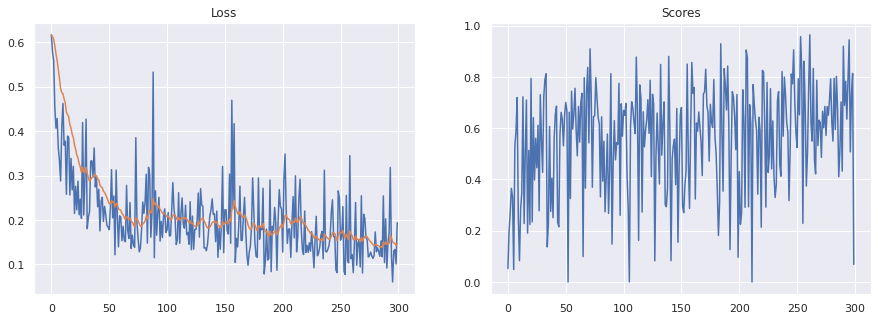

In [ ]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_trainig_results(loss_meter, score_meter)

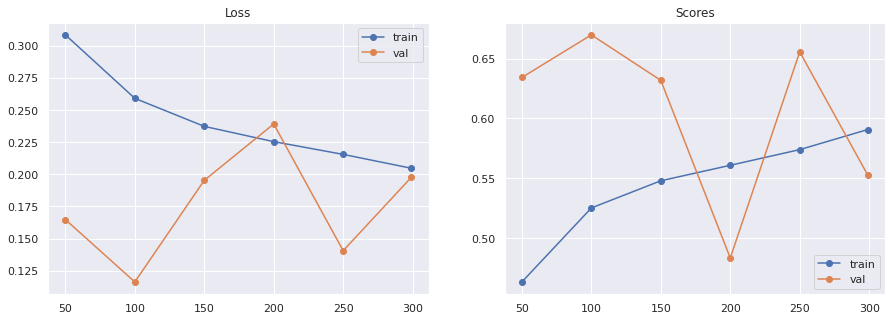

In [ ]:
show_loss(train_info)

 # Dataset

In [10]:
from main import get_dataset

In [64]:
reduce_train = False
train_number = 32
valid_number = 32

seed_everything(seed)

train_dataset, valid_dataset = get_dataset(
    PATH_TO_DATA,
    reduce_train,
    train_number,
    valid_number
)

[data] flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273


In [66]:
sample_data = train_dataset[9]
chip = sample_data['chip']
label = sample_data['label']

chip.shape, label.shape

((2, 256, 256), (256, 256))

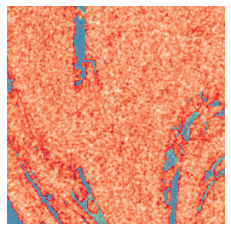

In [67]:
label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)
show_image_and_label(chip[1], label_to_show)

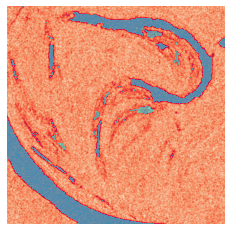

In [59]:
label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)
show_image_and_label(chip[1], label_to_show)

In [24]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)
len(train_loader)

14

In [25]:
%%time
for i, x in enumerate(train_loader):
    pass

CPU times: user 12.1 s, sys: 788 ms, total: 12.8 s
Wall time: 12.8 s


# Run

In [26]:
from main import run
import segmentation_models_pytorch as smp

In [27]:
def get_model():
    encoder_name = 'resnet18'
    encoder_weights = 'imagenet'

    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=2,
        classes=2,
    )
    
    return model

In [28]:
debug_params = dict(
    reduce_train=True,
    train_number=20,
    valid_number=4,

    batch_size_train=2,
    batch_size_valid=2,
    max_iter=5,
    valid_iters=[1, 3, 4],
)

In [29]:
small_dataset_params = dict(
    reduce_train=True,
    train_number=32,
    valid_number=16,

    batch_size_train=4,
    batch_size_valid=4,
    max_iter=200,
    valid_iters=[10, 50, 100, 150, 199],
)

In [30]:
num_train_samples = 9600
batch_size_train = 16

max_iter = num_train_samples // batch_size_train
num_train_samples = batch_size_train * max_iter

max_iter, num_train_samples

(600, 9600)

In [31]:
max_iter=300
valid_step=30

valid_iters = list(np.arange(valid_step-1, max_iter, valid_step))
valid_iters

[29, 59, 89, 119, 149, 179, 209, 239, 269, 299]

In [32]:
# max_iter=300
# valid_iters=[50, 100, 150, 200, 250, 299]

# max_iter=100
# valid_iters=[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

full_params = dict(
    reduce_train=False,
    train_number=0,
    valid_number=0,

    batch_size_train=16,
    batch_size_valid=16,
    max_iter=max_iter,
    valid_iters=valid_iters
)

In [34]:
params = dict(
    path_to_data=PATH_TO_DATA,

    optimizer_name='Adam',
    learning_rate=5e-4, # 5e-4, 3e-4, 1e-3
    weight_decay=0,

    verbose=True
)

params.update(full_params) # full_params, debug_params, small_dataset_params

In [35]:
params

{'batch_size_train': 16,
 'batch_size_valid': 16,
 'learning_rate': 0.0005,
 'max_iter': 300,
 'optimizer_name': 'Adam',
 'path_to_data': '/content/',
 'reduce_train': False,
 'train_number': 0,
 'valid_iters': [29, 59, 89, 119, 149, 179, 209, 239, 269, 299],
 'valid_number': 0,
 'verbose': True,
 'weight_decay': 0}

In [68]:
seed = 2021
seed_everything(seed)

model = get_model().to(device)

train_info = run(model, device, **params)

[run]
[data] flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273
[data] DataLoader size, train: 27, valid: 8
[data] num_epoch: 11.11111111111111, num_train_samples: 4800
[train] started...
[train] iter:   29, loss = 0.57589, score = 0.33305, time: 0:00:31
[valid] iter:   29, loss = 0.36429, score = 0.20377, time: 0:00:31

[train] iter:   59, loss = 0.44061, score = 0.39348, time: 0:01:02
[valid] iter:   59, loss = 0.33179, score = 0.55930, time: 0:01:02

[train] iter:   89, loss = 0.36725, score = 0.44080, time: 0:01:34
[valid] iter:   89, loss = 0.15992, score = 0.66338, time: 0:01:34

[train] iter:  119, loss = 0.32549, score = 0.46383, time: 0:02:05
[valid] iter:  119, loss = 0.12237, score = 0.67222, time: 0:02:05

[train] iter:  149, loss = 0.30142, score = 0.48340, time: 0:02:36
[valid] iter:  149, loss = 0.17479, score = 0.71479, time: 0:02:36

[train] iter:  179, loss = 0.27982, score = 0.50400, time: 0:03:06
[valid] iter:  17

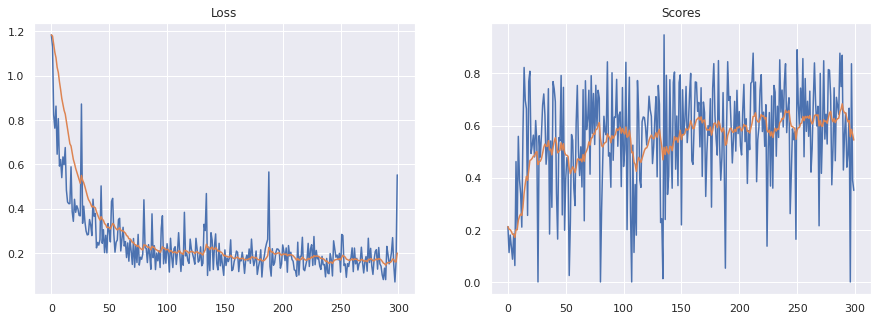

In [69]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_train_metrics(loss_meter, score_meter)

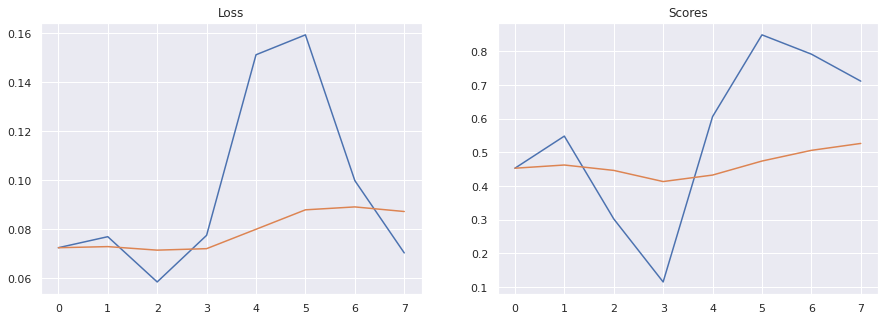

In [87]:
loss_meter = train_info['valid_loss_meter']
score_meter = train_info['valid_score_meter']
show_train_metrics(loss_meter, score_meter)

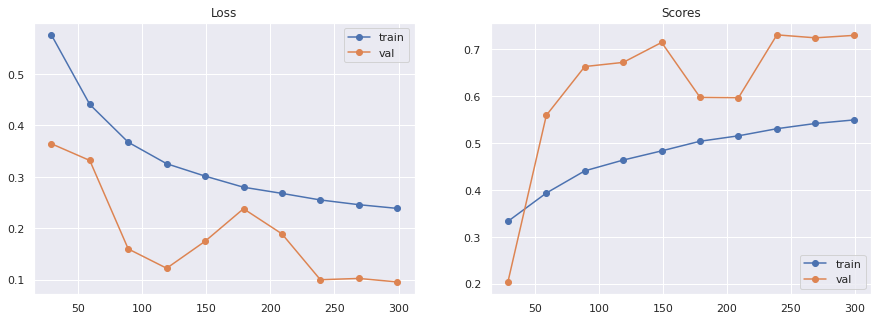

In [73]:
# show_loss_and_score(train_info, start_from=2)
show_loss_and_score(train_info)

# Validation 

In [88]:
from train import validate

In [94]:
loss = nn.CrossEntropyLoss(ignore_index=255)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
loss_meter, score_meter = validate(model, device, valid_loader, loss, print_every=50)

[valid] iter:    0, loss = 0.04323, score = 0.00000, time: 0:00:00
[valid] iter:   50, loss = 0.06142, score = 0.46382, time: 0:00:04
[valid] iter:  100, loss = 0.09352, score = 0.74105, time: 0:00:07


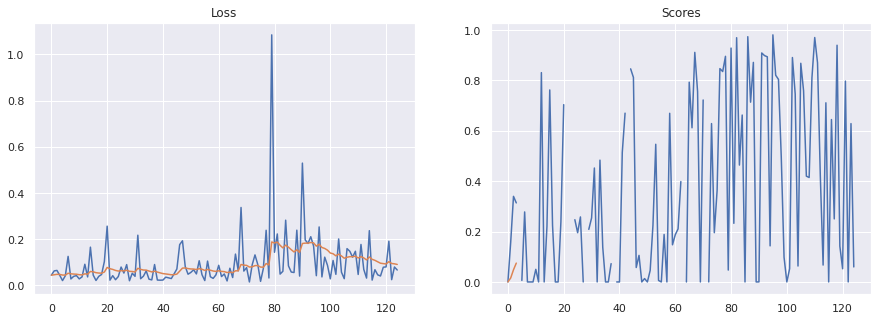

In [95]:
show_train_metrics(loss_meter, score_meter)

# Show predictions

In [85]:
model_path = 'pth/unet_resnet_18_0.pth'
model.load_state_dict(torch.load(model_path))
model = model.eval()

In [75]:
valid_dataset = train_info['valid_dataset']
len(valid_dataset)

125

In [76]:
valid_sample = valid_dataset[1]

chip = valid_sample['chip']
label = valid_sample['label']

chip.shape, label.shape

((2, 512, 512), (512, 512))

In [77]:
from metrics import IoUMeter
from train import compute_prediction
from plot_utils import show_predictions

In [78]:
meter = IoUMeter()

In [79]:
def get_prediction(model, chip, label):
    output = model(torch.tensor(chip).unsqueeze(0).to(device))
    pred = compute_prediction(output).squeeze()
        
    iou = meter.update(pred, torch.tensor(label).to(device))
    print(f'IoU: {iou} \nTotal IoU: {meter.compute_score()}')
    
    return pred

In [80]:
def get_and_show_predictions(index, model, valid_dataset):    
    valid_sample = valid_dataset[index]

    chip = valid_sample['chip']
    
    label = valid_sample['label']  
    label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)
    
    pred = get_prediction(model, chip, label).cpu()
    pred_to_show = np.ma.masked_where(pred == 0, pred)
    
    show_predictions(chip, label_to_show, pred_to_show)

In [81]:
# np.array(meter.history).mean()

IoU: 0.04708905890583992 
Total IoU: 0.04708905890583992


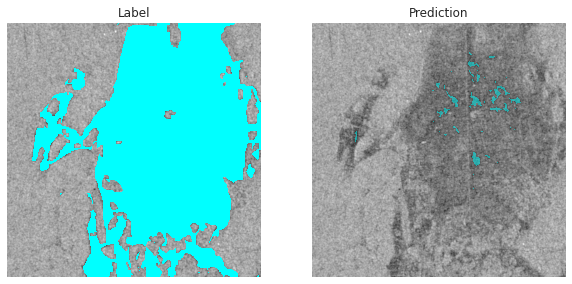

In [97]:
index = 79
meter.reset()
get_and_show_predictions(index, model, valid_dataset)

In [36]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [37]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(valid_dataset)-1,
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    get_and_show_predictions(x, model, valid_dataset)

In [42]:
meter.reset()
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=124), Output()), _dom_classes=('widget…

<function __main__.handle_change>